In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding,Bidirectional
import seaborn as sns
import cv2, shutil, os
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.text import Tokenizer
#import zipfile module
from zipfile import ZipFile
import matplotlib.pyplot as plt
from tensorflow.keras import datasets,layers,models
from keras.models import Sequential, load_model
from sklearn.model_selection import train_test_split

In [10]:
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_train(train_images,class_names,train_labels):
    plt.figure(figsize=(20,10))
    for i in range(5):
        plt.subplot(5,2,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_images[i],cmap=plt.cm.binary)
        # The CIFAR labels happen to be arrays,# which is why you need the extra index
        plt.xlabel(class_names[train_labels[i]])
        plt.show()

In [11]:
# configuration to resolve performance issue
init = tf.compat.v1.global_variables_initializer()
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=4,
                       inter_op_parallelism_threads=4,
                       allow_soft_placement=True)

In [12]:
patent = pd.read_csv("/kaggle/input/patent-abstracts/neural_network_patent_query.csv")
patent.head()

,patent_abstract,patent_date,patent_number,patent_title
0,""" A """"Barometer"""" Neuron enhances stability in...",1996-07-09,5535303,"""""""Barometer"""" neuron for a neural network"""
1,""" This invention is a novel high-speed neural ...",1993-10-19,5255349,"""Electronic neural network for solving """"trave..."
2,An optical information processor for use as a ...,1995-01-17,5383042,3 layer liquid crystal neural network with out...
3,A method and system for intelligent control of...,2001-01-02,6169981,3-brain architecture for an intelligent decisi...
4,A method and system for intelligent control of...,2003-06-17,6581048,3-brain architecture for an intelligent decisi...


In [13]:
tokenizer = Tokenizer(
    num_words=None,
    filters='#$%&()*+-<=>@[\\]^_`{|}~\t\n',
    lower = False,
    split=' '
)
abst = patent['patent_abstract'].values
tokenizer.fit_on_texts(abst)
sequences = tokenizer.texts_to_sequences(abst)
sequences[0][:10]

[305, 16, 7193, 4015, 3472, 2335, 9, 2, 405, 692]

In [14]:
features = []
labels = []

training_length = 5

# Iterate through the sequences of tokens
for seq in sequences:
    for i in range(len(seq)-training_length):
        extract = seq[i:i+training_length+1]
        # Set the features and label
        features.append(extract[:-1])
        labels.append(extract[-1])
features = np.array(features)
features.shape

(453349, 5)

In [17]:
# download glove and unzip it in Notebook.
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2023-01-07 07:43:09--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-01-07 07:43:10--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-01-07 07:43:10--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [18]:
num_words = len(tokenizer.word_index)+1
def embedding_for_vocab(filepath, word_index,embedding_dim):
    vocab_size = len(word_index) + 1
    # Adding again 1 because of reserved 0 index
    embedding_matrix_vocab = np.zeros((vocab_size,embedding_dim))
    with open(filepath,encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix_vocab[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix_vocab
embedding_matrix = embedding_for_vocab('./glove.6B.300d.txt', tokenizer.word_index,300)


In [37]:
from keras.models import Sequential
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding
def create_nlp(embedding_matrix,num_words,training_length):
    model = Sequential()
    # Embedding layer

    if embedding_matrix != []:
        model.add(
        Embedding(input_dim = num_words,
                  input_length = training_length,
                  output_dim=np.shape(embedding_matrix)[1],
                  weights=[embedding_matrix],
                  trainable=False,
                  mask_zero=False))
    else:
        model.add(
        Embedding(input_dim=num_words,
                  input_length = training_length,
                  output_dim=100,
                  mask_zero=False))
        

    # Recurrent layer
    model.add(CuDNNLSTM(256, return_sequences=True))
    model.add(Dropout(0.2))
        # Recurrent layer
    model.add(CuDNNLSTM(256, return_sequences=False))
    model.add(Dropout(0.2))
    # Fully connected layer
    model.add(Dense(128, activation='relu'))

    # Dropout for regularization
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(num_words, activation='softmax'))
    return model


In [20]:
x_train, x_val, y_train, y_val = train_test_split(features, np.array(labels), test_size = 0.2, random_state=43)

In [38]:
model = create_nlp(embedding_matrix,num_words,training_length)
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 5, 300)            5698800   
_________________________________________________________________
cu_dnnlstm_8 (CuDNNLSTM)     (None, 5, 256)            571392    
_________________________________________________________________
dropout_16 (Dropout)         (None, 5, 256)            0         
_________________________________________________________________
cu_dnnlstm_9 (CuDNNLSTM)     (None, 256)               526336    
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)              

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,verbose=1)
with tf.device('/gpu:1'):
    history = model.fit(x_train,y_train,epochs=200,batch_size=5000,validation_data=(x_val,y_val),callbacks=[callback])

Epoch 1/200


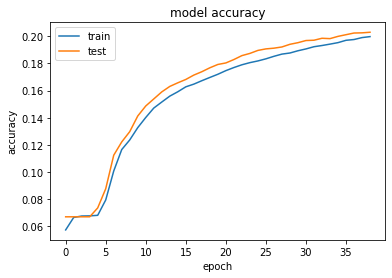

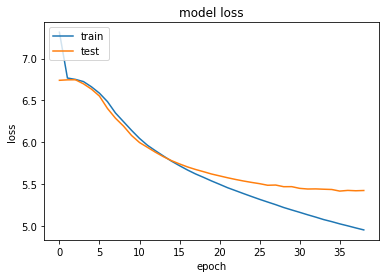

In [40]:
plot_history(history)

In [41]:
wd_idx = tokenizer.word_index
idx = tokenizer.index_word
x, y = x_train[0],y_train[0]
phrase = ' '.join(idx[w] for w in x)
phrase = 'This invention is a novel'
import sys,time
sys.stdout.write(phrase)
for i in range(50):
    u = phrase.split(' ')[i:i+training_length]
    tmp = np.array([wd_idx[w] for w in u]).reshape((1,-1))
    pred = idx[np.argmax(model.predict(tmp))]
    phrase+=' '+pred
    sys.stdout.write(' '+pred)
    time.sleep(0.2)

This invention is a novel

2023-01-07 09:05:05.534876: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 neural network to generate a plurality of input data and the input signal and the input signal and the input signal and the input signal and the input signal and the input signal and the input signal and the input signal and the input signal and the input signal and

In [ ]:
model.save_weights("word.h5")

In [ ]:
patent.iloc[1]['patent_abstract']